C:\Users\lsoledad\Anaconda3\envs\pandas\lib\site-packages\ipykernel\ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-134-f714e5b4a56f>:19: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  table_dict = pd.read_excel('C:/Users/lsoledad/Documents/Diamonds/data_dictionary.xlsx')
C:\Users\lsoledad\Anaconda3\envs\pandas\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterato

        id                                        description character
0    carat                        Carat weight of the diamond   Numeric
1      cut  Describe cut quality of the diamond. Quality i...    String
2    color  Color of the diamond, with D being the best an...    String
3  clarity  How obvious inclusions are within the diamond:...    String
4    depth  depth % :The height of a diamond, measured fro...   Numeric
5    table  table%: The width of the diamond's table expre...   Numeric
6    price           The price of the diamond in muggle money   Numeric
7        x                        length of the diamond in mm   Numeric
8        y                         width of the diamond in mm   Numeric
9        z                         depth of the diamond in mm   Numeric
Aquí empieza el análisis
           cut color clarity    x_mean    y_mean    z_mean
0         Fair     D      I1  7.517500  7.422500  4.905000
1         Fair     D      IF  4.746667  4.686667  2.866667
2     

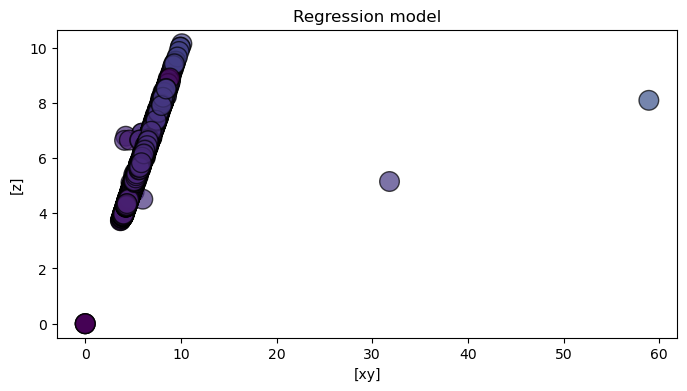

coefficient of determination: 0.9427357348142374
intercept: 0.03571605526309973
slope: [0.53946041 0.07169919]
predicted response:
[2.40954192 2.5123464  2.60473733 ... 3.49631334 3.79219659 3.60164446]


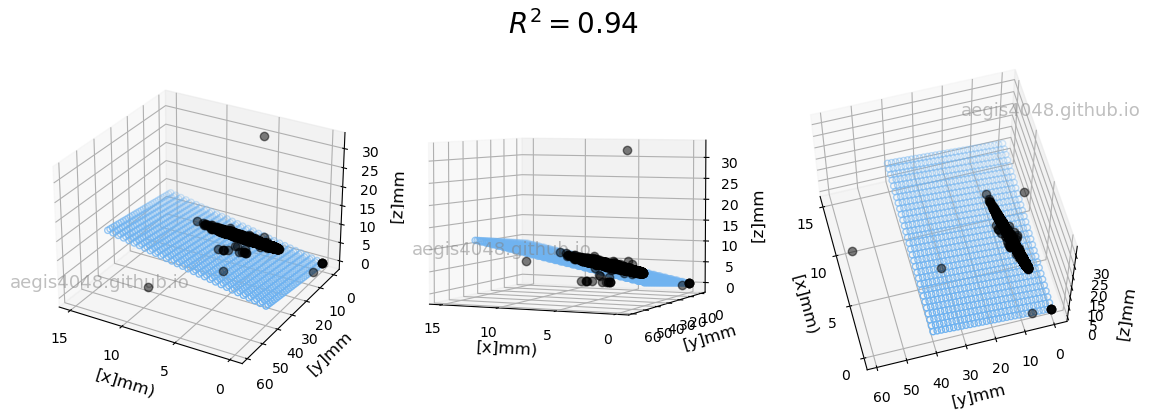

In [134]:
#libraries
import pandas as pd
import numpy as np
import io
import os
import json
import time
import dedupe
import datetime
import matplotlib.pyplot as plt
from causallift import CausalLift
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Read UFO info
def read_data():
    # data---53930
    data = pd.read_csv('C:/Users/lsoledad/Documents/Diamonds/diamonds_data.csv')
    table_dict = pd.read_excel('C:/Users/lsoledad/Documents/Diamonds/data_dictionary.xlsx')
    print(table_dict)
    path = os.listdir('C:/Users/lsoledad/Documents/Diamonds')
    return data,path

def clean_data(data,path):
    data=data[1:]
    #Drop exact duplicates --- 53640 
    Column=data.keys().tolist()
    d= {'Column': ['' for x in range(len(data)+1)]}
    df2 = pd.DataFrame(d)
    for x in Column:
        df2['Column'] = df2['Column'].astype(str).replace(' ','', regex=True) + data[x].fillna(' ').astype(str).replace(' ', '', regex=True)
    
    df3 = df2['Column'][df2['Column'].duplicated(keep=False) == False][1:]
    df3 = data.loc[df3.index][Column]
    
    #Delete Na values in longitude,altitude, city and datetime columns.---53640
    df3=df3[Column].dropna()
    return df3
    

def analysis(df5):
    
    ##### Medias por cualitativo
    cross=df5.groupby(['cut','color','clarity']).agg({'x':['mean'],'y':['mean'],'z':['mean']})
    cross.columns=['x_mean','y_mean','z_mean']
    #cross=pd.crosstab(df5['cut'], [df5['color'],df5['clarity']], aggfunc=None,margins = True)
    print(cross.reset_index())
    row=['Good','Ideal','Premium']
    descr=cross.loc[row][:]
    print(descr)
    ###### cross table that contains only data with similar qualifications to the sample. 
    df1 = df5
    df1=df1[~df1.cut.str.contains('Fair','Very Good')]
    df1=df1[~df1.color.str.contains('F','H')]
    print(df1)
    ###### plot 'x' vs 'y' vs 'z' dependign z of function of y and x 
    fig, ax = plt.subplots(figsize=(8, 4)) # Create the figure and axes object

    plt.scatter(df1['y'], df1['x'],
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=df1['z'])
    plt.title('Regression model')
    plt.xlabel('[xy]')
    plt.ylabel('[z]')
    plt.show()
    #######################################Linear Regression#######################################################

    x=df5['x'].to_numpy()
    y=df5['y'].to_numpy()
    z=df5['z'].to_numpy()

    xy=np.column_stack((x,y))

    model = LinearRegression().fit(xy, z)
    r_sq = model.score(xy, z)
    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)
    y_pred = model.predict(xy)
    print('predicted response:', y_pred, sep='\n')
    
    
    x_pred = np.linspace(0, 15, 30)   # range of x values
    y_pred = np.linspace(0, 40, 30)  # range of y values
    
    
    xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
    
    
    
    model = model.fit(xy, z)
    predicted = model.predict(model_viz)
    
    
    r2 = model.score(xy, z)
    plt.style.use('default')
    ############################################## Plot ################################################
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')

    axes = [ax1, ax2, ax3]

    for ax in axes:
        ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
        ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
        ax.set_xlabel('[x]mm)', fontsize=12)
        ax.set_ylabel('[y]mm', fontsize=12)
        ax.set_zlabel('[z]mm', fontsize=12)
        ax.locator_params(nbins=4, axis='x')
        ax.locator_params(nbins=5, axis='x')

    ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
               transform=ax1.transAxes, color='grey', alpha=0.5)
    ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
               transform=ax2.transAxes, color='grey', alpha=0.5)
    ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
               transform=ax3.transAxes, color='grey', alpha=0.5)

    ax1.view_init(elev=28, azim=120)
    ax2.view_init(elev=4, azim=114)
    ax3.view_init(elev=60, azim=165)

    fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

    fig.tight_layout()




    
def main():
    data,path=read_data()
    df5=clean_data(data,path)
    print('Aquí empieza el análisis')
    analysis(df5)
    
main()